In [41]:
import sys
#sys.path.append('/Users/abadarinath/Applications/anaconda/envs/UdacityNanoCar/lib/python3.5/site-packages')

DATA_DIR = '../CarND-Behavioral-Cloning-Data/data_given/'
DRIVING_LOG = DATA_DIR + 'driving_log.csv'
FINAL_DRIVING_LOG = DATA_DIR + 'final_driving_log.csv'
IMG_DIR = DATA_DIR + 'IMG/'

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
import numpy as np
import pandas as pd
# Visualizations will be shown in the notebook.
%matplotlib inline

#show given image img, or if img is None, load the img from src and show 
def showImage(imgName=None,img=None,title=None):
    if imgName != None:
        imgName=imgName.strip()
        img = mpimg.imread(DATA_DIR+imgName)
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(title)    
    plt.show()    

In [43]:
#load the CSV and output 5 random sample images
driving_log = pd.DataFrame.from_csv(DRIVING_LOG,index_col=False)

n_driving_log = driving_log.shape[0]
print("Given driving log details")
print("Number of rows = ",n_driving_log)
print("Number of features = ",driving_log.shape[1])
print("A few random sample output")
randomImgIndex = np.zeros(5)

Given driving log details
Number of rows =  8036
Number of features =  7
A few random sample output


In [44]:
FLIPPED_IMG_APPEND = "IMG/FLIP/"
import os.path
os.makedirs(os.path.dirname(DATA_DIR+FLIPPED_IMG_APPEND), exist_ok=True)
os.makedirs(os.path.dirname(DATA_DIR+FLIPPED_IMG_APPEND+"/IMG/"), exist_ok=True)

def fligImgAndSave(imgName):
    imgName=imgName.strip()
    if os.path.isfile(DATA_DIR+FLIPPED_IMG_APPEND+imgName):
        return #skip if file already exist
    Image.open(DATA_DIR+imgName).transpose(Image.FLIP_LEFT_RIGHT).save(DATA_DIR+FLIPPED_IMG_APPEND+imgName)

import cv2
SHIFT_IMG_APPEND = "IMG/SHIFT/"
os.makedirs(os.path.dirname(DATA_DIR+SHIFT_IMG_APPEND), exist_ok=True)

def shiftImg(img,shift):
    rows,cols,ch = img.shape
    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[50-shift,50],[200-shift,50],[50-shift,200]])
    M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(img,M,(cols,rows))
    
def shiftImgAndSave(imgName,shift):
    imgName=imgName.strip()
    os.makedirs(os.path.dirname(DATA_DIR+SHIFT_IMG_APPEND+str(shift)+"/IMG/"), exist_ok=True)
    if os.path.isfile(DATA_DIR+SHIFT_IMG_APPEND+imgName):
        return #skip if file already exist
    img = mpimg.imread(DATA_DIR+imgName)
    dst = shiftImg(img,shift)
    mpimg.imsave(DATA_DIR+SHIFT_IMG_APPEND+str(shift)+"/"+imgName,dst)

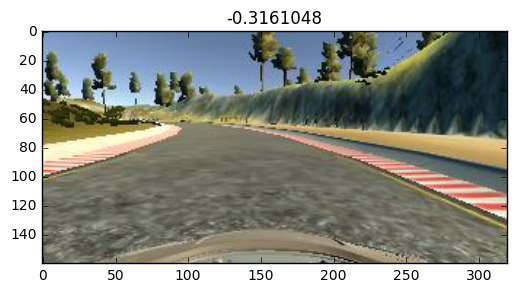

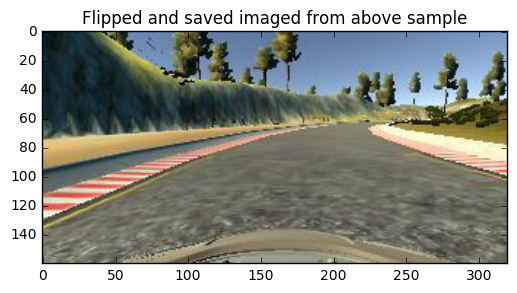

In [45]:
for i in range(5):
    randomImgIndex[i] = randint(0,n_driving_log)
tmp=randomImgIndex[4]
showImage(driving_log['center'][tmp],None,driving_log['steering'][tmp])
from PIL import Image
trackImg = Image.open(DATA_DIR+driving_log['center'][tmp]).transpose(Image.FLIP_LEFT_RIGHT).save(IMG_DIR+'tmp_horizontal_flip.jpg')
showImage('IMG/tmp_horizontal_flip.jpg',None,"Flipped and saved imaged from above sample")

In [89]:
#lets do the same for all the given images to augment the data
imgSrc=list() # combine any image 
steering=list()
throttle=list()
brake=list()
speed=list()

def addIntoFinalDrivingList(imgSrc_inp,steering_inp,throttle_inp,brake_inp,speed_inp):
    imgSrc.append(imgSrc_inp.strip())
    steering.append(steering_inp)
    throttle.append(throttle_inp)
    brake.append(brake_inp)
    speed.append(speed_inp)

def saveNewDrivingLog():
    df = pd.DataFrame(data={'imgSrc':imgSrc,'steering':steering,'throttle':throttle,'brake':brake,'speed':speed})
    df.to_csv(FINAL_DRIVING_LOG,index=False)
    
print("Converting and augmenting data")
for i in range(n_driving_log):
    if i%20 == 0:
        print(i/n_driving_log)
    # create adjusted steering measurements for the side camera images
    steering_center = driving_log['steering'][i]
    if steering_center == 0 and np.random.choice([1,2,3,4,5,6,7,8,9,10]) >= 2:
        pass # ignore the 0 value input because we have too many of them and lets not overfit the data to 0
    else:
        correction = 0.15 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        addIntoFinalDrivingList(driving_log['center'][i],steering_center,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])
        addIntoFinalDrivingList(driving_log['left'][i],steering_left,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])
        addIntoFinalDrivingList(driving_log['right'][i],steering_right,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])

        fligImgAndSave(driving_log['center'][i])
        fligImgAndSave(driving_log['left'][i])
        fligImgAndSave(driving_log['right'][i])

        addIntoFinalDrivingList(FLIPPED_IMG_APPEND+driving_log['center'][i].strip(),-steering_center,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])
        addIntoFinalDrivingList(FLIPPED_IMG_APPEND+driving_log['left'][i].strip(),-steering_left,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])
        addIntoFinalDrivingList(FLIPPED_IMG_APPEND+driving_log['right'][i].strip(),-steering_right,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])

        if steering_center > 0.15 or steering_center < -0.15:
            shift_correction = 0.004 # this is a parameter to tune
            shift = np.random.choice([-50,-40,-30,-20,-10,10,20,30,40,50]) # this is a parameter to tune

            shiftImgAndSave(driving_log['center'][i],shift)
            shiftImgAndSave(driving_log['left'][i],shift)
            shiftImgAndSave(driving_log['right'][i],shift)

            steering_center = driving_log['steering'][i] + (shift * shift_correction)
            steering_left = steering_center + correction + (shift * shift_correction)
            steering_right = steering_center - correction + (shift * shift_correction)

            addIntoFinalDrivingList(SHIFT_IMG_APPEND+str(shift)+"/"+driving_log['center'][i].strip(),steering_center,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])
            addIntoFinalDrivingList(SHIFT_IMG_APPEND+str(shift)+"/"+driving_log['left'][i].strip(),steering_left,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])
            addIntoFinalDrivingList(SHIFT_IMG_APPEND+str(shift)+"/"+driving_log['right'][i].strip(),steering_right,driving_log['throttle'][i],driving_log['brake'][i],driving_log['speed'][i])

    
saveNewDrivingLog()
print(FINAL_DRIVING_LOG + " is saved with new augmented data")

Converting and augmenting data
0.0
0.0024888003982080635
0.004977600796416127
0.007466401194624191
0.009955201592832254
0.012444001991040319
0.014932802389248382
0.017421602787456445
0.019910403185664508
0.022399203583872575
0.024888003982080638
0.0273768043802887
0.029865604778496764
0.03235440517670483
0.03484320557491289
0.03733200597312095
0.039820806371329016
0.042309606769537086
0.04479840716774515
0.04728720756595321
0.049776007964161276
0.05226480836236934
0.0547536087605774
0.057242409158785465
0.05973120955699353
0.06222000995520159
0.06470881035340965
0.06719761075161772
0.06968641114982578
0.07217521154803384
0.0746640119462419
0.07715281234444997
0.07964161274265803
0.0821304131408661
0.08461921353907417
0.08710801393728224
0.0895968143354903
0.09208561473369836
0.09457441513190643
0.09706321553011449
0.09955201592832255
0.10204081632653061
0.10452961672473868
0.10701841712294674
0.1095072175211548
0.11199601791936287
0.11448481831757093
0.11697361871577899
0.1194624191139

Given FINAL driving log details
Number of rows =  29097
Number of features =  5
A few random sample output


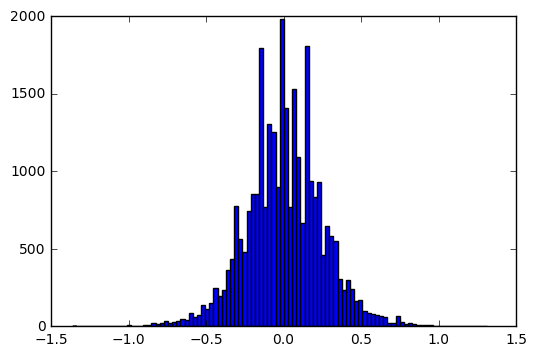

In [46]:
#load the CSV and output 5 random sample images
final_driving_log = pd.DataFrame.from_csv(FINAL_DRIVING_LOG,index_col=False)

n_final_driving_log = final_driving_log.shape[0]
print("Given FINAL driving log details")
print("Number of rows = ",n_final_driving_log)
print("Number of features = ",final_driving_log.shape[1])
print("A few random sample output")

plt.hist(final_driving_log['steering'],bins=100)
plt.show()

In [47]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    # return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


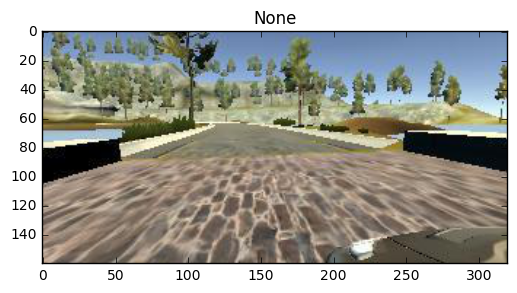

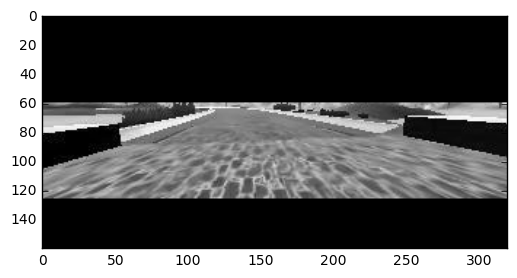

In [48]:
#read a single image and dermine the clipping angle

tesImg = 'IMG/FLIP/IMG/right_2016_12_01_13_32_54_674.jpg'#final_driving_log['imgSrc'][0]
showImage(tesImg)

image = mpimg.imread(DATA_DIR+tesImg)
image = grayscale(image)
region_of_intrest = [[0,60],[320,60],[320,125],[0,125]]
image = region_of_interest(image,np.array([region_of_intrest]))
plt.figure(1)
plt.imshow(image, cmap='gray')
plt.show()

# hence we can carry forward the "region of intrest" into the models forward

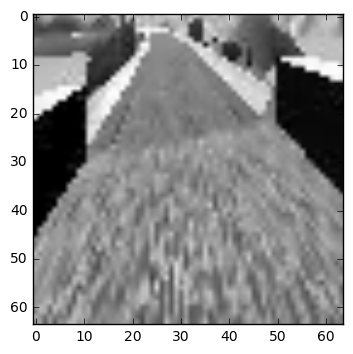

(64, 64, 1)


In [49]:

def preprocessInputImage(src):
    row,col = 64,64
    img = cv2.imread(src,0)
    img = cv2.cvtColor(cv2.imread(DATA_DIR+final_driving_log['imgSrc'][i]),cv2.COLOR_BGR2GRAY)
    crop_img = img[60:125, 0:320]
    img = cv2.resize(crop_img, (row,col))
    #plt.figure(1)
    #plt.imshow(img, cmap='gray')
    #plt.show()
    return np.reshape(img,(row,col,1))

image = Image.open(DATA_DIR+tesImg).convert('L').crop((0, 60, 320, 125)).resize((64,64))
# print(img.shape)
plt.figure(1)
plt.imshow(image, cmap='gray')
plt.show()
image_array = np.reshape(np.asarray(image),(64,64,1))
print(image_array.shape)

In [56]:
import os
import csv
#Construct the keras model
from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.layers import Lambda, ELU
from keras.layers.normalization import BatchNormalization
from random import shuffle

samples = []
with open(FINAL_DRIVING_LOG) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = IMG_DIR+batch_sample[1].split('/')[-1]
                center_image = preprocessInputImage(name)
                try:
                    center_angle = float(batch_sample[3])
                except ValueError:
                    center_angle = 0
                images.append(center_image)
                angles.append(center_angle)
                #plt.figure(1)
                #plt.imshow(cv2.cvtColor(center_image,cv2.COLOR_BGR2RGB))
                #plt.show()
                #print('test',name,center_angle,center_image.shape)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=256)
validation_generator = generator(validation_samples, batch_size=256)

#print(next(train_generator))

In [57]:
ch, row, col = 1, 64, 64  # image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(row,col,ch),output_shape=(row,col,ch)))
model.add(Convolution2D(3, 1, 1, subsample=(1, 1), border_mode='same',init = 'he_normal'))
model.add(BatchNormalization())
model.add(ELU())
model.add(Convolution2D(16, 5, 5, subsample=(4, 4), border_mode="same",init = 'he_normal'))
model.add(BatchNormalization())
model.add(ELU())
model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode="same",init = 'he_normal'))
model.add(BatchNormalization())
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same",init = 'he_normal'))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(ELU())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 64, 64, 1)     0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 64, 64, 3)     6           lambda_5[0][0]                   
____________________________________________________________________________________________________
batchnormalization_17 (BatchNorm (None, 64, 64, 3)     12          convolution2d_17[0][0]           
____________________________________________________________________________________________________
elu_16 (ELU)                     (None, 64, 64, 3)     0           batchnormalization_17[0][0]      
___________________________________________________________________________________________

In [ ]:

history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=30,verbose = 1)
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Epoch 1/30
22528/23278 [============================>.] - ETA: 1s - loss: 0.6848

In [ ]:

from keras.callbacks import ModelCheckpoint
import json

if not os.path.exists("./output"): 
    os.makedirs("./output")

print("\nSaving model weights and configuration file.")

with open('model.json', 'w') as f:
    json.dump(model.to_json(), f)
# Save model weights to file
model.save('model.h5')

print("Saved model to disk")